#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET).

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion

- No significant difference between both models
- No support for early stopping

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [3]:
base = 'MLPHeb-non-binary-coacts-2019-10-04'
exps = [
    os.path.join(base, exp) for exp in [
        'mlp-heb', 
        'mlp-SET',
        'mlp-WeightedMag',
        'mlp-sparse',
    ]
]
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

exp_name /Users/mcaporale/nta/results/MLPHeb-non-binary-coacts-2019-10-04/mlp-heb/experiment_state-2019-10-04_01-34-19.json
exp_name /Users/mcaporale/nta/results/MLPHeb-non-binary-coacts-2019-10-04/mlp-SET/experiment_state-2019-10-04_01-34-19.json
exp_name /Users/mcaporale/nta/results/MLPHeb-non-binary-coacts-2019-10-04/mlp-WeightedMag/experiment_state-2019-10-04_01-34-19.json
exp_name /Users/mcaporale/nta/results/MLPHeb-non-binary-coacts-2019-10-04/mlp-sparse/experiment_state-2019-10-04_01-34-19.json


In [4]:
df.head(5)['hebbian_prune_perc']

0    0.3
1    0.3
2    0.3
3    0.3
4    0.3
Name: hebbian_prune_perc, dtype: object

In [5]:
# replace hebbian prine
df['hebbian_prune_perc'] = df['hebbian_prune_perc'].replace(np.nan, 0.0, regex=True)
df['weight_prune_perc'] = df['weight_prune_perc'].replace(np.nan, 0.0, regex=True)

In [6]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'val_acc_all',
       'epochs', 'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'batch_norm', 'data_dir', 'dataset_name', 'debug_sparse', 'device',
       'hebbian_grow', 'hebbian_prune_perc', 'hidden_sizes', 'input_size',
       'learning_rate', 'lr_gamma', 'lr_milestones', 'lr_scheduler', 'model',
       'momentum', 'moving_average_alpha', 'network', 'num_classes', 'on_perc',
       'optim_alg', 'pruning_early_stop', 'test_noise',
       'use_binary_coactivations', 'weight_decay', 'weight_prune_perc'],
      dtype='object')

In [7]:
df.shape

(171, 43)

In [8]:
df.iloc[1]

Experiment Name                            1_model=DSNNMixedHeb,on_perc=0.005
train_acc_max                                                        0.112367
train_acc_max_epoch                                                        31
train_acc_min                                                         0.10525
train_acc_min_epoch                                                        25
train_acc_median                                                     0.112367
train_acc_last                                                       0.112367
val_acc_max                                                            0.1135
val_acc_max_epoch                                                           0
val_acc_min                                                            0.0958
val_acc_min_epoch                                                           4
val_acc_median                                                         0.1135
val_acc_last                                                    

In [9]:
df.groupby('model')['model'].count()

model
DSNNMixedHeb       82
DSNNWeightedMag    41
SparseModel        48
Name: model, dtype: int64

 ## Analysis

Experiment Details

In [10]:
# Did any  trials failed?
df[df["epochs"]<30]["epochs"].count()

0

In [11]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(171, 43)

In [12]:
# which ones failed?
# failed, or still ongoing?
df_origin['failed'] = df_origin["epochs"]<30
df_origin[df_origin['failed']]['epochs']

Series([], Name: epochs, dtype: int64)

In [13]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


##### Does improved weight pruning outperforms regular SET

In [14]:
agg(['model'])

val_acc_max_epoch val_acc_max                      model
                       round_mean         min    max   mean    std count
model                                                                   
DSNNMixedHeb                   39       0.114  0.983  0.842  0.261    82
DSNNWeightedMag                35       0.114  0.981  0.863  0.261    41
SparseModel                    40       0.114  0.975  0.769  0.314    48

In [15]:
agg(['on_perc'])

val_acc_max_epoch val_acc_max                      model
               round_mean         min    max   mean    std count
on_perc                                                         
0.000                   0       0.114  0.114  0.114  0.000     9
0.005                   0       0.114  0.114  0.114  0.000     9
0.010                  30       0.314  0.710  0.549  0.145     9
0.015                  19       0.383  0.793  0.600  0.166     9
0.020                  46       0.822  0.952  0.888  0.056     9
0.025                  41       0.853  0.959  0.903  0.047     9
0.030                  47       0.899  0.971  0.940  0.029     8
0.035                  35       0.906  0.970  0.945  0.025     8
0.040                  44       0.928  0.976  0.957  0.020     8
0.045                  47       0.934  0.976  0.959  0.017     8
0.050                  38       0.941  0.978  0.963  0.014     8
0.055                  41       0.942  0.979  0.964  0.015     8
0.060                  47       0.945  0.980  0.967  0.014     8
0.065                  48       0.952  0.979  0.969  0.011     8
0.070                  51       0.955  0.980  0.972  0.011     8
0.075                  52       0.960  0.980  0.972  0.009     8
0.080                  51       0.958  0.981  0.973  0.010     8
0.085                  54       0.961  0.981  0.974  0.008     8
0.090                  45       0.957  0.982  0.974  0.009     8
0.095                  41       0.959  0.981  0.974  0.009     8
0.100                  44       0.967  0.983  0.975  0.006     5

In [16]:
def model_name(row):
    
    if row['model'] == 'DSNNWeightedMag':
        return 'DSNN-WM'

    elif row['model'] == 'DSNNMixedHeb':
        if row['hebbian_prune_perc'] == 0.3:
           return 'SET'

        elif row['weight_prune_perc'] == 0.3:
           return 'DSNN-Heb'

    elif row['model'] == 'SparseModel':
        return 'Static'
    
    assert False, "This should cover all cases. Got {} h - {} w - {}".format(row['model'], row['hebbian_prune_perc'], row['weight_prune_perc'])

def test(val):
    print(type(val))
    print(val)
    print()

In [17]:
df['model2'] = df.apply(model_name, axis=1) 

In [18]:
fltr = df['model2'] != 'Sparse'
agg(['on_perc', 'model2'], filter=fltr)

val_acc_max_epoch val_acc_max                      model
                        round_mean         min    max   mean    std count
on_perc model2                                                           
0.000   DSNN-Heb                 0       0.114  0.114  0.114  0.000     2
        DSNN-WM                  0       0.114  0.114  0.114  0.000     2
        SET                      0       0.114  0.114  0.114  0.000     2
        Static                   0       0.114  0.114  0.114  0.000     3
0.005   DSNN-Heb                 1       0.114  0.114  0.114  0.000     2
        DSNN-WM                  0       0.114  0.114  0.114  0.000     2
        SET                      0       0.114  0.114  0.114  0.000     2
        Static                   0       0.114  0.114  0.114  0.000     3
0.010   DSNN-Heb                38       0.610  0.635  0.623  0.017     2
        DSNN-WM                 38       0.678  0.710  0.694  0.022     2
        SET                      2       0.536  0.662  0.599  0.089     2
        Static                  38       0.314  0.413  0.369  0.051     3
0.015   DSNN-Heb                13       0.710  0.737  0.724  0.019     2
        DSNN-WM                 19       0.689  0.793  0.741  0.074     2
        SET                      4       0.526  0.739  0.632  0.151     2
        Static                  32       0.383  0.412  0.401  0.016     3
0.020   DSNN-Heb                62       0.949  0.952  0.951  0.002     2
        DSNN-WM                 32       0.934  0.948  0.941  0.010     2
        SET                      4       0.854  0.854  0.854  0.000     2
        Static                  74       0.822  0.844  0.833  0.011     3
0.025   DSNN-Heb                55       0.956  0.959  0.957  0.002     2
        DSNN-WM                 26       0.943  0.950  0.946  0.005     2
        SET                      8       0.865  0.869  0.867  0.003     2
        Static                  65       0.853  0.871  0.861  0.009     3
0.030   DSNN-Heb                80       0.968  0.971  0.969  0.002     2
        DSNN-WM                 35       0.959  0.962  0.961  0.003     2
        SET                     10       0.899  0.906  0.903  0.005     2
        Static                  64       0.925  0.932  0.928  0.004     2
0.035   DSNN-Heb                36       0.966  0.970  0.968  0.002     2
        DSNN-WM                 58       0.964  0.966  0.965  0.001     2
...                            ...         ...    ...    ...    ...   ...
0.065   SET                     88       0.952  0.954  0.953  0.001     2
        Static                  37       0.966  0.967  0.966  0.000     2
0.070   DSNN-Heb                53       0.979  0.980  0.980  0.001     2
        DSNN-WM                 32       0.980  0.980  0.980  0.000     2
        SET                     86       0.955  0.956  0.956  0.001     2
        Static                  32       0.970  0.972  0.971  0.001     2
0.075   DSNN-Heb                36       0.979  0.980  0.980  0.001     2
        DSNN-WM                 43       0.978  0.980  0.979  0.001     2
        SET                     88       0.960  0.961  0.960  0.000     2
        Static                  40       0.968  0.968  0.968  0.000     2
0.080   DSNN-Heb                36       0.980  0.981  0.981  0.001     2
        DSNN-WM                 60       0.981  0.981  0.981  0.000     2
        SET                     74       0.958  0.959  0.958  0.001     2
        Static                  34       0.972  0.973  0.973  0.000     2
0.085   DSNN-Heb                46       0.980  0.981  0.980  0.000     2
        DSNN-WM                 46       0.980  0.980  0.980  0.000     2
        SET                     84       0.961  0.962  0.961  0.000     2
        Static                  39       0.973  0.974  0.973  0.001     2
0.090   DSNN-Heb                42       0.982  0.982  0.982  0.000     2
        DSNN-WM                 36       0.980  0.980  0.980  0.000     2
        SET          

In [19]:
# translate model names
rcParams['figure.figsize'] = 16, 8
# d = {
#     'DSNNWeightedMag': 'DSNN',
#     'DSNNMixedHeb': 'SET',
#     'SparseModel': 'Static',        
# }
# df_plot = df.copy()
# df_plot['model'] = df_plot['model'].apply(lambda x, i: model_name(x, i))

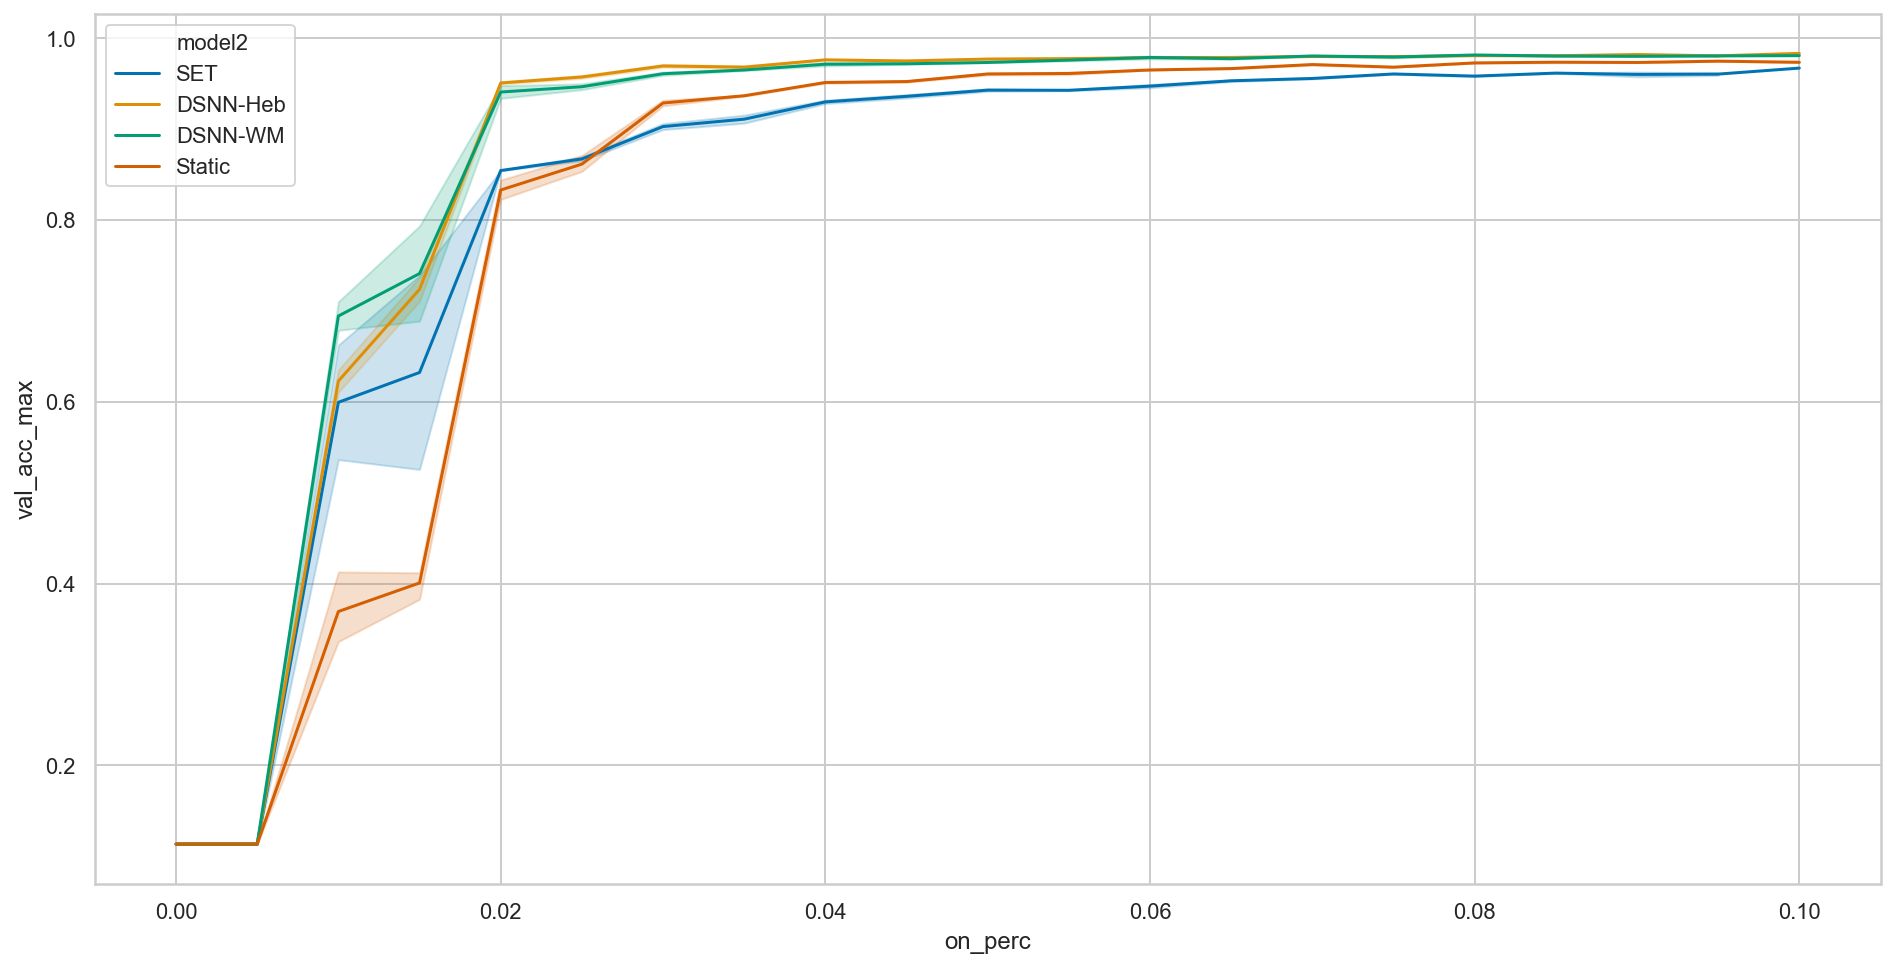

In [20]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df, x='on_perc', y='val_acc_max', hue='model2')

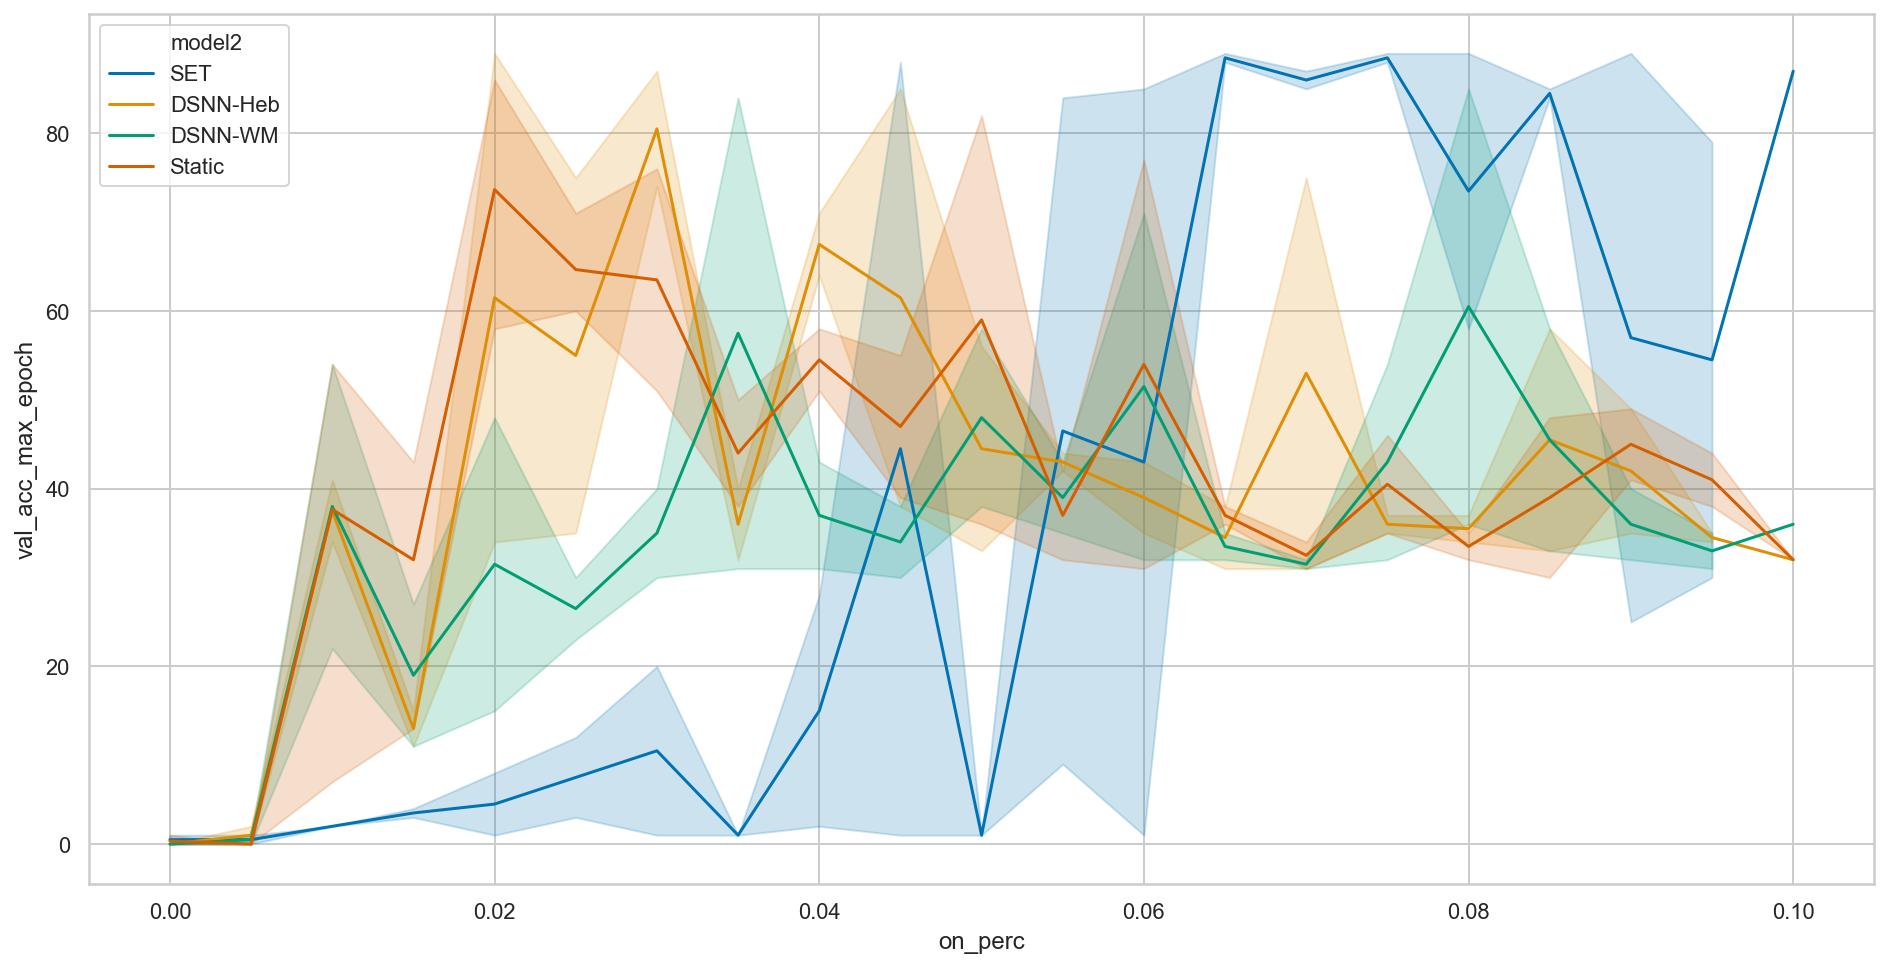

In [22]:
rcParams['figure.figsize'] = 16, 8
filter = df['model'] != 'Static'
sns.lineplot(data=df[filter], x='on_perc', y='val_acc_max_epoch', hue='model2')

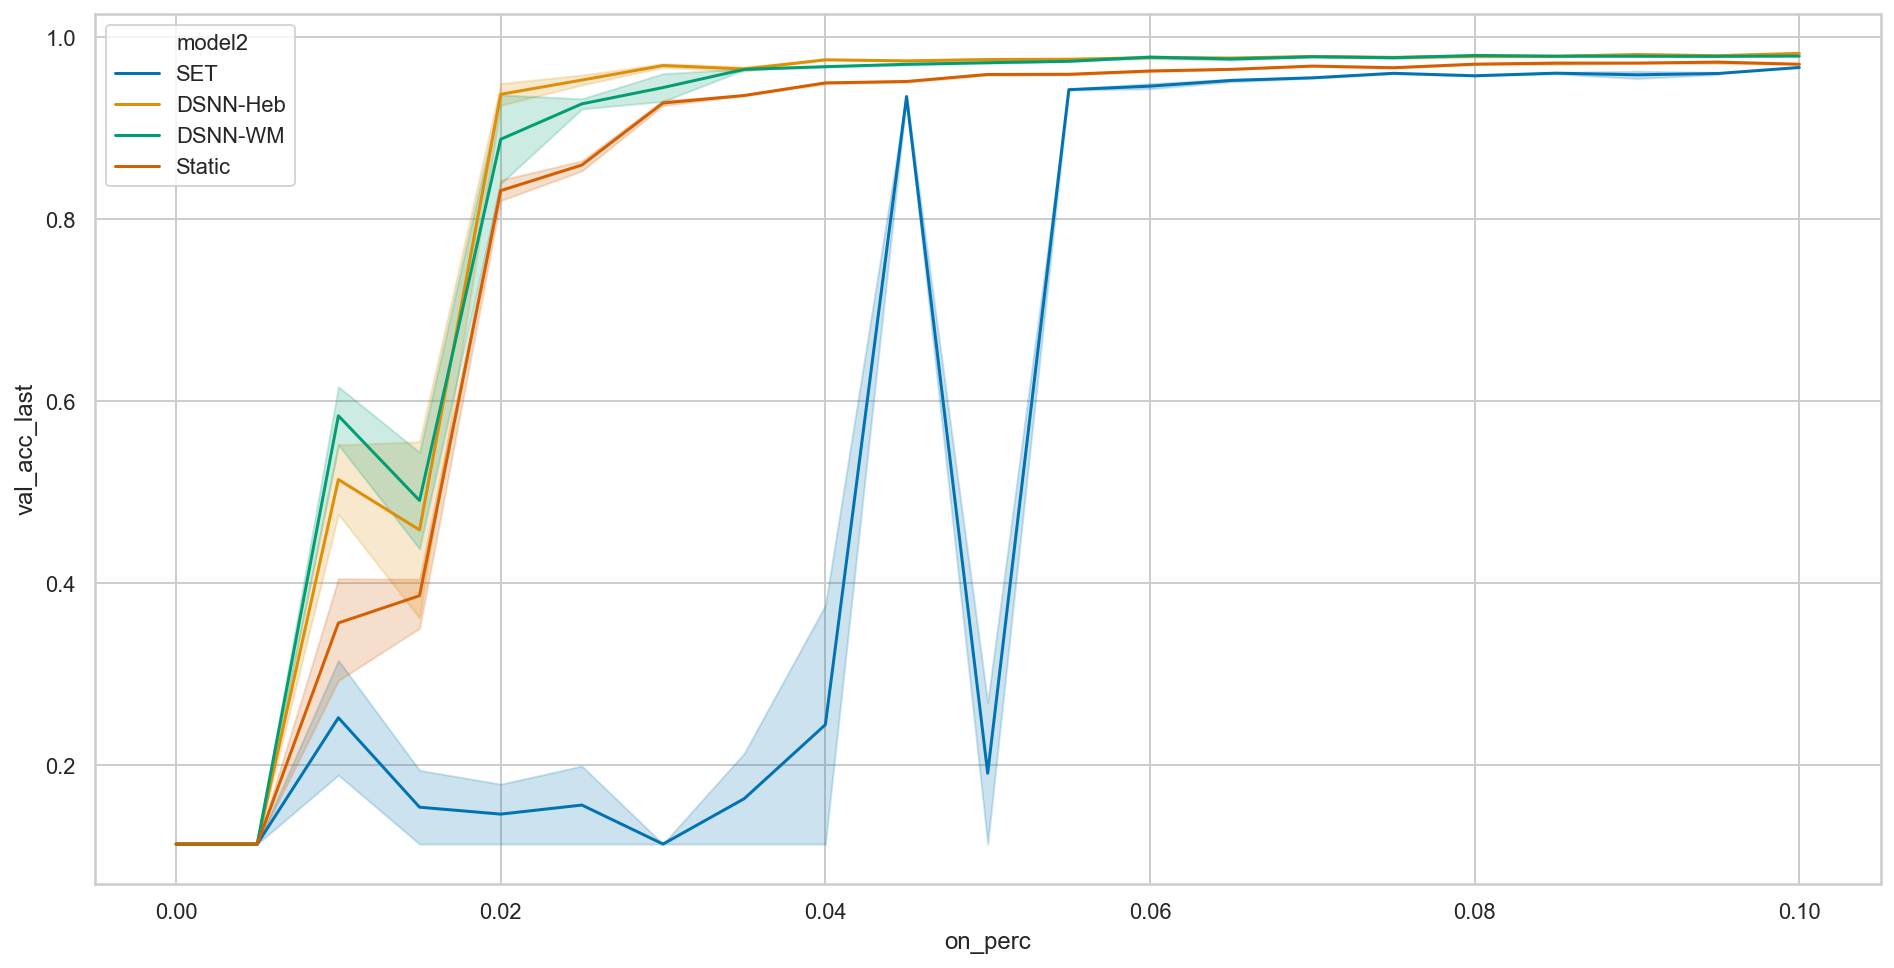

In [24]:
sns.lineplot(data=df, x='on_perc', y='val_acc_last', hue='model2')